In [1]:
from pathlib import Path
from datetime import datetime, date, timedelta
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Open raw data.

In [2]:
data_folder = Path('../data/')
output_folder = Path('../output/')
fn = Path(data_folder, 'INC-4176 PRA Request for Mr. Lecher.csv')
outfile = Path(data_folder, 'assessments.csv')
raw_df = pd.read_csv(fn)

## Filter out family assessments.

In [3]:
init = len(raw_df)

df = raw_df[~raw_df['AssessmentName'].str.contains('Families')].copy()

curr = len(df)

print(f'Removed {init - curr} from {init} rows. {curr} rows remaining, or {round(curr / init * 100,1)}% of the original dataset.')

Removed 18578 from 158509 rows. 139931 rows remaining, or 88.3% of the original dataset.


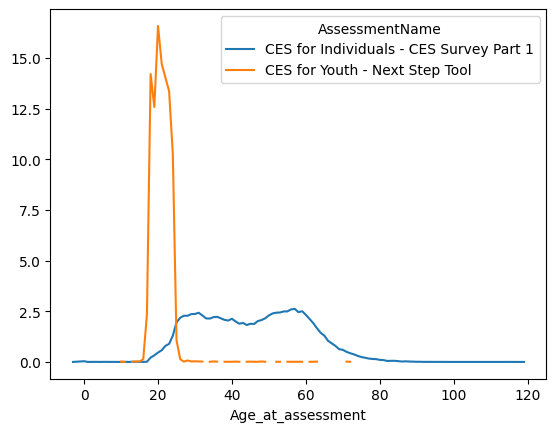

In [4]:
agedf = df.groupby(['Age_at_assessment','AssessmentName'])['Unique_client_ID'].count().unstack().copy()
age_chart = agedf.div(agedf.sum()).mul(100).copy()

age_chart.to_csv(Path(output_folder, 'age_distribution.csv'))

# Chart for context
age_chart.plot()
pass

In [5]:
# Bucket age into groups
df['Age_group_at_assessment'] = pd.cut(
    df['Age_at_assessment'],
    bins=[df['Age_at_assessment'].min() - 1,18,25,45,60, df['Age_at_assessment'].max() + 1],
    include_lowest=True,
    right=False,
    labels=['Under 18', '18-24', '25-44','45-59','60+']
)

## Filter out columns that are entirely NULL

In [6]:
init = set(df.columns)

df.dropna(how='all', axis='columns', inplace=True)

curr = set(df.columns)

print(f'Removed {len(init - curr)} of {len(init)} columns. {len(curr)} columns remaining.')

print('Removed columns:')
for col in list(init - curr): print(f'\t•  {col}')

Removed 13 of 76 columns. 63 columns remaining.
Removed columns:
	•  Have the members of your family changed in the last 180 days, due to things like divorce, your kids coming back to live...?
	•  After school total time without interaction: 2 or more hours per day for children aged 12 or younger?
	•  In the last 180 days have any children lived with family or friends because of your homelessness or housing situation?
	•  Does any single member of your household have a medical condition, mental health concerns, and experience with problemat...?
	•  After school total time without interaction: 3 or more hours per day for children aged 13 or older?
	•  IF THERE ARE SCHOOL-AGED CHILDREN:  Do your children attend school more often than not each week?
	•  Do you anticipate any other adults or children coming to live with you within the first 180 days of being housed?
	•  Do your older kids spend 2 or more hours on a typical day helping their younger sibling(s) with things like getting ready

## Add race/ethnicity column.

In [7]:
def categorize_race_eth(row):
    race = row['Race']
    ethnicity = row['Ethnicity']
    if not isinstance(race, str) or not isinstance(ethnicity, str):
        return "Other/Unknown"
    if race == "White" and 'Non-' in ethnicity:
        return "White"
    elif race == 'Black, African American, or African' and 'Non-' in ethnicity:
        return 'Black'
    elif race == 'Asian or Asian American' and 'Non-' in ethnicity:
        return 'Asian'
    elif 'Hispanic/Latin' in ethnicity:
        return 'Latino'
    elif 'Unknown' in race or 'Unknown' in ethnicity:
        return "Unknown"
    else:
        return "Other"
    return "Other/Unknown"

df['Race/Ethnicity'] = df.apply(categorize_race_eth, axis = 1)

In [8]:
df.groupby(['Race/Ethnicity','Ethnicity','Race']).size().to_frame("count")

count
Race/Ethnicity Ethnicity                       Race                                                
Asian          Non-Hispanic/Non-Latin(a)(o)(x) Asian or Asian American                         2026
Black          Non-Hispanic/Non-Latin(a)(o)(x) Black, African American, or African            56252
Latino         Hispanic/Latin(a)(o)(x)         American Indian, Alaska Native, or Indigenous   1447
                                               Asian or Asian American                          111
                                               Black, African American, or African             1588
                                               Multiple Races                                   752
                                               Native Hawaiian or Pacific Islander              499
                                               Unknown                                         6168
                                               White                                          31283
Other          Non-Hispanic/Non-Latin(a)(o)(x) American Indian, Alaska Native, or Indigenous   1061
                                               Multiple Races                                  2226
                                               Native Hawaiian or Pacific Islander              794
Unknown        Non-Hispanic/Non-Latin(a)(o)(x) Unknown                                          916
               Unknown                         American Indian, Alaska Native, or Indigenous     28
                                               Asian or Asian American                           23
                                               Black, African American, or African              279
                                               Multiple Races                                    26
                                               Native Hawaiian or Pacific Islander                8
                                               Unknown                                         2915
                                               White                                            263
White          Non-Hispanic/Non-Latin(a)(o)(x) White                                          31266

## Add acuity group column

In [9]:
def acuity(row, total_score='TOTAL_SCORE'):
    score = row[total_score]
    assessment = row['AssessmentName']
    if ('Individuals' in assessment and score > 11) or\
       ("Families" in assessment and score > 8) or\
       ('Youth' in assessment and score > 7):
        return '3/High Acuity'
    elif ('Individuals' in assessment and 11 >= score and score > 3) or\
       ("Families" in assessment and 8 >= score and score > 3) or\
       ("Youth" in assessment and 7 >= score and score > 3):
        return '2/Mid Acuity'
    elif ('Individuals' in assessment and score <= 3) or\
       ("Families" in assessment and score <= 3) or\
       ("Youth" in assessment and score <= 3):
        return '1/Low Acuity'
    
df['Acuity'] = df.apply(acuity,total_score='TOTAL_SCORE',axis=1)

## Calculate time from assessment to intervention

In [10]:
df['AssessmentDate_dt'] = df['AssessmentDate'].apply(pd.to_datetime, errors='coerce')
df['InterventionDate_dt'] = df['Intervention_Date'].apply(pd.to_datetime, errors='coerce')
df['DaysFromAssessmentToInterventionDate'] = df['InterventionDate_dt'].sub(df['AssessmentDate_dt']).dt.days

df['AssessmentPredatesIntervention'] = df['DaysFromAssessmentToInterventionDate'].ge(0)

df['AssessmentYear'] = df['AssessmentDate_dt'].dt.year
df['InterventionYear'] = df['InterventionDate_dt'].dt.year

In [11]:
no_assessment_date = df['AssessmentDate'].isna().sum()
no_intervention_date = df['Intervention_Date'].isna().sum()
negative_days = df['DaysFromAssessmentToInterventionDate'].lt(0).sum()

messed_up_assessment_dates = len(df[(~df['AssessmentDate'].isna()) & df['AssessmentDate_dt'].isna()])
messed_up_intervention_dates = len(df[(~df['Intervention_Date'].isna()) & df['InterventionDate_dt'].isna()]['Intervention_Date'])
messed_up_dates = messed_up_assessment_dates + messed_up_intervention_dates
print(f"• {messed_up_dates} row(s) have dates that could not be parsed\n• {no_assessment_date} row(s) have no assessment date\n• {no_intervention_date} row(s) have no intervention date\n• {negative_days} row(s) have intervention dates prior to their assessment date")

• 1 row(s) have dates that could not be parsed
• 0 row(s) have no assessment date
• 52978 row(s) have no intervention date
• 4826 row(s) have intervention dates prior to their assessment date


In [12]:
print('Intervention dates broken down by survey type:')
df[~df['Intervention_Date'].isna()].groupby(['AssessmentName',]).size().to_frame("count").sort_values(by='count', ascending=False)

Intervention dates broken down by survey type:


,count
AssessmentName,
CES for Individuals - CES Survey Part 1,78837
CES for Youth - Next Step Tool,8116


In [13]:
print('Most common interventions where there were no dates:')
df[df['Intervention_Date'].isna()].groupby(['Intervention',]).size().to_frame("count").sort_values(by='count', ascending=False).head(5)

Most common interventions where there were no dates:


,count
Intervention,
Assessed Only,13312
Permanently Housed,8700
"Matched to Permanent Housing, Not Yet Housed",7616
"Currently active in ""Street Outreach"" program",6920
"Currently active in ""Services Only"" program",6314


In [14]:
print('Intervention dates prior to assessment dates broken down by survey type:')
df[df['DaysFromAssessmentToInterventionDate'].lt(0)].groupby('AssessmentName').size().to_frame("count").sort_values(by='count', ascending=False)

Intervention dates prior to assessment dates broken down by survey type:


,count
AssessmentName,
CES for Individuals - CES Survey Part 1,4453
CES for Youth - Next Step Tool,373


In [15]:
print('Most common interventions with interventions dates that predate the assessment date:')
df[df['DaysFromAssessmentToInterventionDate'].lt(0)][['Intervention', 'AssessmentName']].value_counts().unstack()

Most common interventions with interventions dates that predate the assessment date:


AssessmentName,CES for Individuals - CES Survey Part 1,CES for Youth - Next Step Tool
Intervention,,
Deceased,1.0,NaN
Exited to a permanent destination,20.0,5.0
Exited to a place not meant for habitation,232.0,17.0
Exited to a temporary destination,511.0,47.0
Exited to an institutional destination,118.0,19.0
Exited to an other or unknown destination,2592.0,173.0
"Matched to Permanent Housing, Not Yet Housed",268.0,22.0
Permanently Housed,711.0,90.0


In [16]:
df['MonthsFromAssessmentToInterventionDate'] = df['InterventionDate_dt'].sub(df['AssessmentDate_dt']).astype('timedelta64[M]')

## Add Assessment Year

In [17]:
df['AssessmentYear'] = df['AssessmentDate_dt'].dt.year

In [18]:

print(f"• We have {df['AssessmentName'].str.contains('Indiv').sum()} adult surveys and {df['AssessmentName'].str.contains('Youth').sum()} youth surveys.")
print(f"• We have a total of {len(df)} surveys.")
print(f"• The assessment span between {df['AssessmentDate_dt'].min()} and {df['AssessmentDate_dt'].max()}.")

• We have 127442 adult surveys and 12489 youth surveys.
• We have a total of 139931 surveys.
• The assessment span between 2016-01-02 00:00:00 and 2022-10-30 00:00:00.


## Calculate Individual sub-scores

In [19]:
individuals = df[df['AssessmentName'].str.contains('Indiv')].copy()

In [20]:
# A. HISTORY OF HOUSING & HOMELESSNESS (/2)

individuals['CALC_HISTORY_SLEEPING_LOCATION'] = ~individuals['Where do you and your family sleep most frequently?'].isin(['Shelters','Transitional Housing','Safe Haven'])
individuals['CALC_HISTORY_HISTORY_OF_HOMELESSNESS'] = individuals['How long has it been since you and your family lived in permanent stable housing?'].isin(['1 - 2 years', '2 years or more']) |\
    individuals['In the last three years, how many times have you and your family been homeless?'].isin(['4 times', '5 or more times'])

In [21]:
# B. RISKS (/4)

def calculate_interactions(row):
    total = 0
    for v in row.values:
        if isinstance(v, str) and not "Client" in v:
            i = int(v[0])
            total += i
    return total >= 4


individuals['CALC_RISKS_EMERGENCY_SERVICE_USE'] = individuals[[
    'In the past six months, how many times have you or anyone in your family received health care at an emergency department/room?',
    'In the past six months, how many times have you or anyone in your family taken an ambulance to the hospital?',
    'In the past six months, how many times have you or anyone in your family been hospitalized as an inpatient?',
    'In the past six months, how many times have you or anyone in your family used a crisis service, including sexual assault?',
    'In the past six months, how many times have you or anyone in your family talked to police because they witnessed a crime,?',
    'In the past six months, how many times have you or anyone in your family stayed one or more nights in a holding cell,jail...?'
    ]].apply(calculate_interactions, axis=1)
individuals['CALC_RISKS_RISK_OF_HARM'] = individuals[["Have you or anyone in your family been attacked or beaten up since theyve become homeless?",
    "Have you or any family member threatened to or tried to harm themself or anyone else in the last year?"
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
individuals['CALC_RISKS_LEGAL_ISSUES'] = individuals['Do you or any member of the family have any legal stuff going on right now that may result in them being locked up...?'].eq('Yes')
individuals['CALC_RISKS_RISK_OF_EXPLOITATION'] = individuals[[
    'Does anybody force or trick you or anyone in your family to do things that you do not want to do',
    'Do you or anyone in your family ever do things that may be considered to be risky like exchange sex for money, run drugs...?'
   ]].apply(lambda r: 'Yes' in r.values, axis=1)


In [22]:
# C. SOCIALIZATION & DAILY FUNCTIONS (/4)

individuals['CALC_SOCIALIZATION_MONEY_MANAGEMENT'] = individuals['Is there any person, past landlord, business, bookie, dealer, or government group like the IRS that thinks you or anyone...?'].eq('Yes') |\
    individuals['Do you or anyone in your family get any money from the government, a pension, an inheritance, working under the table,...?'].eq('No')
individuals['CALC_SOCIALIZATION_MEANINGFUL_DAILY_ACTIVITY'] = individuals['Does everyone in your family have planned activities, other than just surviving, that make them f'].eq('No')
individuals['CALC_SOCIALIZATION_SELFCARE'] = individuals['Is everyone in your family currently able to take care of basic needs like bathing, changing clothes, using a restroom...?'].eq('No')
individuals['CALC_SOCIALIZATION_SOCIAL_RELATIONSHIPS'] = individuals['Is your familys current homelessness in any way caused by a relationship that broke down, an unhealthy or abusive rel...?'].eq('Yes')

In [23]:
# D. WELLNESS (/6)

individuals['CALC_WELLNESS_PHYSICAL_HEALTH'] = individuals[[
    'Has your family ever had to leave an apartment, shelter program, or other place you were staying because of the physi...?',
    'Do you or anyone in your family have any chronic health issues with your liver, kidneys, stomach, lungs or heart?',
    'If there was space available in a program that specifically assists people that live with HIV or AIDS, would that be of ...?',
    'Does anyone in your family have any physical disabilities that would limit the type of housing you could access, ',
    'When someone in your family is sick or not feeling well, does your family avoid getting medical help?',
    '37. Are you currently pregnant, have you ever been pregnant, or have you ever gotten someone pregnant? (NST)?'
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
individuals['CALC_WELLNESS_SUBSTANCE_USE'] = individuals[[
    'Has drinking or drug use by you or anyone in your family led your family to being kicked out of an apartment ',
    'Will drinking or drug use make it difficult for your family to stay housed or afford your housing?',
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
individuals['CALC_WELLNESS_MENTAL_HEALTH'] = individuals[[
    'Trouble Maintaining Housing because: A mental health issue or concern?',
    'Trouble Maintaining Housing because: A past head injury?',
    'Trouble Maintaining Housing because: A learning disability, developmental disability, or other impairment?',
    'Do you or anyone in your family have any mental health or brain issues that would make it hard for your family to live ind...?'
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
individuals['CALC_WELLNESS_TRIMORBIDITY'] = individuals['CALC_WELLNESS_MENTAL_HEALTH'] & \
                                            individuals['CALC_WELLNESS_SUBSTANCE_USE'] & \
                                            individuals['CALC_WELLNESS_PHYSICAL_HEALTH']
individuals['CALC_WELLNESS_MEDICATIONS'] = individuals[[
    'Are there any medications that a doctor said you or anyone in your family should be taking that, for whatever reason, they...?',
    'Are there any medications like painkillers that you or anyone in your family dont take the way the doctor prescribed or ...?',
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
individuals['CALC_WELLNESS_ABUSE_AND_TRAUMA'] = individuals['Has your familys current period of homelessness been caused by an experience of emotional, physical psychological sexual...?'].eq('Yes')

### Calculate section scores and total score

In [24]:
for section in ['CALC_HISTORY', 'CALC_RISKS', 'CALC_SOCIALIZATION', 'CALC_WELLNESS']:
    individuals[f'{section}_SUB_SCORE'] = individuals[[col for col in individuals.columns if col.startswith(f'{section}_')]].apply(sum ,axis=1)

In [25]:
subscores = [ col for col in individuals.columns if col.startswith('CALC_') and col.endswith('_SUB_SCORE')]
subscores.append('GENERAL_SUB_SCORE')

individuals['CALC_TOTAL_SCORE'] = individuals[subscores].sum(axis=1)

### Evaluating sub-score harmony

In [26]:
individuals['CALC_TOTAL_SCORE'].sub(individuals['TOTAL_SCORE']).value_counts()

 0    125873
 1      1567
-1         2
dtype: int64

In [27]:
individuals['CALC_HISTORY_SUB_SCORE'].sub(
    individuals['HISTORY_SUB_SCORE']
).value_counts()

0    125875
1      1567
dtype: int64

In [28]:
individuals['CALC_RISKS_SUB_SCORE'].sub(
    individuals['RISKS_SUB_SCORE']
).value_counts()

0    127441
1         1
dtype: int64

In [29]:
individuals['CALC_SOCIALIZATION_SUB_SCORE'].sub(
    individuals['SOCIALIZATION_SUB_SCORE']
).value_counts()

 0    127441
-1         1
dtype: int64

In [30]:
individuals['CALC_WELLNESS_SUB_SCORE'].sub(
    individuals['WELLNESS_SUB_SCORE']
).value_counts()

 0    127441
-2         1
dtype: int64

## Calculate youth sub-scores

In [31]:
youth = df[df['AssessmentName'].str.contains('Youth')].copy()

In [32]:
# C. HISTORY OF HOUSING & HOMELESSNESS (/2)

youth['CALC_HISTORY_SLEEPING_LOCATION'] = ~youth['5. Where do you sleep most frequently? (NST)'].isin(['Shelters','Transitional Housing','Safe Haven'])
youth['CALC_HISTORY_HISTORY_OF_HOMELESSNESS'] = youth['How long has it been since you and your family lived in permanent stable housing?'].isin(['1 - 2 years', '2 years or more']) |\
    youth['In the last three years, how many times have you and your family been homeless?'].isin(['4 times', '5 or more times'])

In [33]:
# D. RISKS (/4)

def calculate_interactions(row):
    total = 0
    for v in row.values:
        if isinstance(v, str) and not "Client" in v:
            i = int(v[0])
            total += i
    return total >= 4


youth['CALC_RISKS_EMERGENCY_SERVICE_USE'] = youth[[
    'In the past six months, how many times have you or anyone in your family received health care at an emergency department/room?',
    'In the past six months, how many times have you or anyone in your family taken an ambulance to the hospital?',
    'In the past six months, how many times have you or anyone in your family been hospitalized as an inpatient?',
    'In the past six months, how many times have you or anyone in your family used a crisis service, including sexual assault?',
    'In the past six months, how many times have you or anyone in your family talked to police because they witnessed a crime,?',
    'In the past six months, how many times have you or anyone in your family stayed one or more nights in a holding cell,jail...?'
    ]].apply(calculate_interactions, axis=1)
youth['CALC_RISKS_RISK_OF_HARM'] = youth[["Have you or anyone in your family been attacked or beaten up since theyve become homeless?",
    "Have you or any family member threatened to or tried to harm themself or anyone else in the last year?"
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
youth['CALC_RISKS_LEGAL_ISSUES'] = youth[['Do you or any member of the family have any legal stuff going on right now that may result in them being locked up...?',
    '18. Were you ever incarcerated when younger than age 18? (NST)'
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
youth['CALC_RISKS_RISK_OF_EXPLOITATION'] = youth[[
    'Does anybody force or trick you or anyone in your family to do things that you do not want to do',
    'Do you or anyone in your family ever do things that may be considered to be risky like exchange sex for money, run drugs...?'
   ]].apply(lambda r: 'Yes' in r.values, axis=1)


In [34]:
# E. SOCIALIZTAION & DAILY FUNCTIONING (/5)

youth['CALC_SOCIALIZATION_MONEY_MANAGEMENT'] = youth['Is there any person, past landlord, business, bookie, dealer, or government group like the IRS that thinks you or anyone...?'].eq('Yes') |\
    youth['Do you or anyone in your family get any money from the government, a pension, an inheritance, working under the table,...?'].eq('No')
youth['CALC_SOCIALIZATION_MEANINGFUL_DAILY_ACTIVITY'] = youth['Does everyone in your family have planned activities, other than just surviving, that make them f'].eq('No')
youth['CALC_SOCIALIZATION_SELFCARE'] = youth['Is everyone in your family currently able to take care of basic needs like bathing, changing clothes, using a restroom...?'].eq('No')
youth['CALC_SOCIALIZATION_SOCIAL_RELATIONSHIPS'] = youth[[
    'Is lack of stable housing...25. Because you ran away from your family home, a group home or a foster home? (NST)',
    'Is lack of stable housing...26. Because of a difference in religious or cultural beliefs from your parents, ...? (NST)',
    'Is lack of stable housing...27. Because your family or friends caused you to become homeless? (NST)',
    'Is lack of stable housing...28. Because of conflicts around gender identity or sexual orientation? (NST)',
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
youth['CALC_SOCIALIZATION_USE_TRAUMA'] = youth[[
    'Is lack of stable housing...29. Because of violence at home between family members? (NST)',
    'Is your familys current homelessness in any way caused by a relationship that broke down, an unhealthy or abusive rel...?'
    ]].apply(lambda r: 'Yes' in r.values, axis=1)

In [35]:
# F. WELLNESS (/5)

youth['CALC_WELLNESS_PHYSICAL_HEALTH'] = youth[[
    'Has your family ever had to leave an apartment, shelter program, or other place you were staying because of the physi...?',
    'Do you or anyone in your family have any chronic health issues with your liver, kidneys, stomach, lungs or heart?',
    'If there was space available in a program that specifically assists people that live with HIV or AIDS, would that be of ...?',
    'Does anyone in your family have any physical disabilities that would limit the type of housing you could access, ',
    'When someone in your family is sick or not feeling well, does your family avoid getting medical help?',
    '37. Are you currently pregnant, have you ever been pregnant, or have you ever gotten someone pregnant? (NST)?',
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
youth['CALC_WELLNESS_SUBSTANCE_USE'] = youth[[
    'Has drinking or drug use by you or anyone in your family led your family to being kicked out of an apartment ',
    'Will drinking or drug use make it difficult for your family to stay housed or afford your housing?',
    '41. If youve ever used marijuana, did you ever try it at age 12 or younger? (NST)',
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
youth['CALC_WELLNESS_MENTAL_HEALTH'] = youth[[
    'Trouble Maintaining Housing because: A mental health issue or concern?',
    'Trouble Maintaining Housing because: A past head injury?',
    'Trouble Maintaining Housing because: A learning disability, developmental disability, or other impairment?',
    'Do you or anyone in your family have any mental health or brain issues that would make it hard for your family to live ind...?',           
    ]].apply(lambda r: 'Yes' in r.values, axis=1)
youth['CALC_WELLNESS_TRIMORBIDITY'] =   youth['CALC_WELLNESS_PHYSICAL_HEALTH'] &\
                                        youth['CALC_WELLNESS_SUBSTANCE_USE'] &\
                                        youth['CALC_WELLNESS_MENTAL_HEALTH']
youth['CALC_WELLNESS_MEDICATIONS'] = youth[[
    'Are there any medications that a doctor said you or anyone in your family should be taking that, for whatever reason, they...?',
    'Are there any medications like painkillers that you or anyone in your family dont take the way the doctor prescribed or ...?',
    ]].apply(lambda r: 'Yes' in r.values, axis=1)

### Calculate section scores and total score

In [36]:
for section in ['CALC_HISTORY', 'CALC_RISKS', 'CALC_SOCIALIZATION', 'CALC_WELLNESS']:
    youth[f'{section}_SUB_SCORE'] = youth[[col for col in youth.columns if col.startswith(f'{section}_')]].apply(sum ,axis=1)

In [37]:
subscores = [ col for col in youth.columns if col.startswith('CALC_') and col.endswith('_SUB_SCORE')]
subscores.append('GENERAL_SUB_SCORE')

youth['CALC_TOTAL_SCORE'] = youth[subscores].sum(axis=1)

### Evaluating sub-score harmony

In [38]:
youth['CALC_TOTAL_SCORE'].sub(
    youth['TOTAL_SCORE']
).value_counts()

0    12459
1       30
dtype: int64

In [39]:
youth['CALC_HISTORY_SUB_SCORE'].sub(
    youth['HISTORY_SUB_SCORE']
).value_counts()

0    12459
1       30
dtype: int64

In [40]:
youth['CALC_RISKS_SUB_SCORE'].sub(
    youth['RISKS_SUB_SCORE']
).value_counts()

0    12489
dtype: int64

In [41]:
youth['CALC_SOCIALIZATION_SUB_SCORE'].sub(
    youth['SOCIALIZATION_SUB_SCORE']
).value_counts()

0    12489
dtype: int64

In [42]:
youth['CALC_WELLNESS_SUB_SCORE'].sub(
    youth['WELLNESS_SUB_SCORE']
).value_counts()

0    12489
dtype: int64

## Export data

### Merge youth and individual calculated data

In [43]:
calculated_cols = list((set(individuals.columns) | set(youth.columns)) - set(df.columns))

In [44]:
cols = ['Unique_client_ID']
cols.extend(calculated_cols)

calc_df = pd.concat([youth, individuals])[cols]

### Merge calculated and CPRA data

In [45]:
cols = ['Unique_client_ID',
'Race/Ethnicity',
'Veteran status',
'SPA',
'Gender',
'Age_group_at_assessment',
'Intervention',
'InterventionYear',
'AssessmentPredatesIntervention',
'AssessmentName',
'AssessmentYear',
'Acuity',
'AcuityScore',
'TOTAL_SCORE',
'GENERAL_SUB_SCORE',
'HISTORY_SUB_SCORE',
'RISKS_SUB_SCORE',
'SOCIALIZATION_SUB_SCORE',
'WELLNESS_SUB_SCORE']

outdf = df[cols].merge(calc_df, on='Unique_client_ID').copy()

In [48]:
ordered_cols = ['Unique_client_ID',
'Race/Ethnicity',
'Veteran status',
'SPA',
'Gender',
'Age_group_at_assessment',
'Intervention',
'InterventionYear',
'AssessmentPredatesIntervention',
'AssessmentName',
'AssessmentYear',
'Acuity',
'AcuityScore',
'TOTAL_SCORE',
'GENERAL_SUB_SCORE',
'HISTORY_SUB_SCORE',
'RISKS_SUB_SCORE',
'SOCIALIZATION_SUB_SCORE',
'WELLNESS_SUB_SCORE',
'CALC_TOTAL_SCORE',
'CALC_HISTORY_SUB_SCORE',
'CALC_HISTORY_SLEEPING_LOCATION',
'CALC_HISTORY_HISTORY_OF_HOMELESSNESS',
'CALC_RISKS_SUB_SCORE',
'CALC_RISKS_EMERGENCY_SERVICE_USE',
'CALC_RISKS_RISK_OF_HARM',
'CALC_RISKS_LEGAL_ISSUES',
'CALC_RISKS_RISK_OF_EXPLOITATION',
'CALC_SOCIALIZATION_SUB_SCORE',
'CALC_SOCIALIZATION_MONEY_MANAGEMENT',
'CALC_SOCIALIZATION_MEANINGFUL_DAILY_ACTIVITY',
'CALC_SOCIALIZATION_SELFCARE',
'CALC_SOCIALIZATION_SOCIAL_RELATIONSHIPS',
'CALC_SOCIALIZATION_USE_TRAUMA',
'CALC_WELLNESS_SUB_SCORE',
'CALC_WELLNESS_PHYSICAL_HEALTH',
'CALC_WELLNESS_SUBSTANCE_USE',
'CALC_WELLNESS_MENTAL_HEALTH',
'CALC_WELLNESS_TRIMORBIDITY',
'CALC_WELLNESS_MEDICATIONS',
'CALC_WELLNESS_ABUSE_AND_TRAUMA']

In [49]:
(
  outdf[ordered_cols]
  .apply(lambda x: x.astype('Int64') if x.dtype=='float64' else x)
  .to_csv(Path(data_folder, outfile), index=False)
)